# First Section: Imports

In [1]:
import json 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency


# RQ1

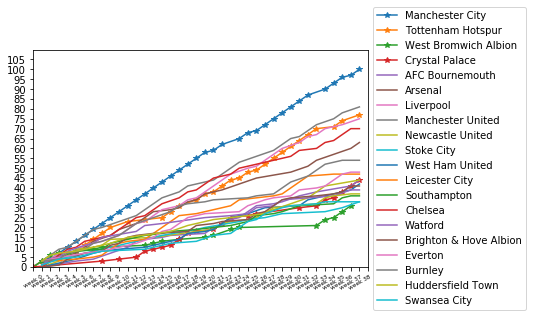

In [2]:
#import json 
#import pandas as pd
#import matplotlib.pyplot as plt
#import numpy as np

#Load the joson files
itMatch = pd.read_json(r'/home/tiago/Scrivania/Libri Magistrale/1st semester/ADM/HomeWork2/matches/matches_England.json')
team=pd.read_json(r'/home/tiago/Scrivania/Libri Magistrale/1st semester/ADM/HomeWork2/teams.json')

#load the match.json into list
jf=open('/home/tiago/Scrivania/Libri Magistrale/1st semester/ADM/HomeWork2/matches/matches_England.json')
jfs=jf.read()
jfdata=json.loads(jfs)

#clean data -  This drops are need to improve efficiency
#team 
team.drop('area', axis=1, inplace=True)
team.drop('officialName', axis=1, inplace=True)
team.drop('type', axis=1, inplace=True)
team.drop('city', axis=1, inplace=True)

#print('itMatch after\n', itMatch)
#itMatch

#add column with thw two team and remove the teamsData
first=[]
second=[]
for e in jfdata:
    first.append(list(e['teamsData'].keys())[0])
    second.append(list(e['teamsData'].keys())[1])
    
itMatch['team1']=first
itMatch['team2']=second

colToDrop=['seasonId', 'dateutc', 'teamsData', 'venue', 'wyId', 'label', 'referees', 'duration', 'competitionId', 'date']
itMatch.drop(colToDrop, axis=1, inplace=True)

#drop the matches with winner = 0

#rowToDrop=itMatch[itMatch.winner==0]
#itMatch.drop(rowToDrop.index, inplace=True)

#drop the matches that are not played yet
rowToDrop=itMatch.loc[itMatch.status!='Played']
itMatch.drop(rowToDrop.index, inplace=True)

itMatch.drop('status', axis=1, inplace=True)

#divide match into matches winner from someone and matches with a tied 

itMatchWin=itMatch.loc[itMatch['winner']!=0]
#print('itMAtch win\n', itMatchWin)

itMatchTied=itMatch.loc[itMatch['winner']==0]
itMatchTied.drop('winner', axis=1, inplace=True)
#print('itMAtch tied\n', itMatchTied)

#saving in a json file
#export=itMatch.to_json(r'/home/tiago/Scrivania/Libri Magistrale/1st semester/ADM/HomeWork2/matches/USmatches_Italy.json')

#Merge win match with team how wins
teamMatchWin=pd.merge(itMatchWin, team, left_on='winner', right_on='wyId', how='outer')

#Merge tied match with the two teams of the match
itMatchTied.loc[:,('team1')]=itMatchTied.loc[:, ('team1')].astype(int)
itMatchTied.loc[:,('team2')]=itMatchTied.loc[:, ('team2')].astype(int)
teamMatchTied=pd.merge(itMatchTied, team, left_on='team1', right_on='wyId', how='outer')
teamMatchTied.rename(columns={'name':'name_1'}, inplace=True)
teamMatchTied=pd.merge(teamMatchTied, team, left_on='team2', right_on='wyId', how='outer')
teamMatchTied.rename(columns={'name':'name_2'}, inplace=True)

# remove some row with NaN value
teamMatchWin.dropna(inplace=True)

teamMatchWin['roundId']=teamMatchWin['roundId'].astype(int)
teamMatchWin['gameweek']=teamMatchWin['gameweek'].astype(int)
teamMatchWin['winner']=teamMatchWin['winner'].astype(int)
#print('teamMatchWin\n', teamMatchWin)


d={}
for index, row in teamMatchWin.iterrows(): #inizilization of a dictionary with k: name of the team and value a list of list; 
                                        #the fist element of internal list is the week, the second is the score
    d[str(row.loc['name'])]=[[0, 0]]


#we  want iterate over whe weeks to add to the dict a pair of (week, score) in order to obtain the point x, y for a plot 


for i in range(1, 39):
    weekI=teamMatchWin.loc[teamMatchWin['gameweek']==i]
    weekIT=teamMatchTied.loc[teamMatchTied['gameweek']==i]
    
    #MatchWin
    
    for index, row in weekI.iterrows():
        #print(row['name'])
        listOfTeam=d[row.loc['name']]
        #print(listOfTeam)
        newScore=listOfTeam[len(listOfTeam)-1][1]+3
        d[row.loc['name']].append([i, newScore])
        
    #MAtchTied
    for index, row in weekIT.iterrows():
        #print(row)
        listOfTeam=d[row.loc['name_1']]
        #print(listOfTeam)
        newScore=listOfTeam[len(listOfTeam)-1][1]+1
        d[row.loc['name_1']].append([i, newScore])
        
        #print(row['name'])
        listOfTeam=d[row.loc['name_2']]
        #print(listOfTeam)
        newScore=listOfTeam[len(listOfTeam)-1][1]+1
        d[row.loc['name_2']].append([i, newScore])

#looking for longhest winning streak and longhest loosing streak
win1=''
win2=''
los1=''
los2=''

#winner

w=''
nw=0
for j in range(2):
    for k, v in d.items():
        #print(k)
        n=0
        prev=v[0]
        for i in range(1, len(v)):
            att=v[i]
            if att[0]==prev[0]+1:
                n+=1
            else:
                if n>nw and k!=win1:
                    nw=n
                    w=k
                n=0
            prev=att
    
    
    nw=0
    if j==0:
        win1=w
    else:
        win2=w

#print('win1 ', win1, 'win2', win2)

#save data of two "winner" to show them separately 
w1=d[win1]
vec1=[i for [i, j] in w1]
wee1=[j for [i, j] in w1]
w2=d[win2]
vec2=[i for [i, j] in w2]
wee2=[j for [i, j] in w2]


#lost
w=''
nw=0
for j in range(2):
    for k, v in d.items():
        #print(k)
        n=0
        prev=v[0]
        for i in range(1, len(v)):
            att=v[i]
            
            n=att[0]-prev[0]
            if n>nw and k!=los1:
                nw=n
                w=k
            n=0
            prev=att
    
    
    nw=0
    if j==0:
        los1=w
    else:
        los2=w

#print('l1 ', los1, 'l2', los2)

#save data of two "lores" to show them separately 
l1=d[los1]
vec1l=[i for [i, j] in l1]
wee1l=[j for [i, j] in l1]
l2=d[los2]
vec2l=[i for [i, j] in l2]
wee2l=[j for [i, j] in l2]


#delete the firt element \[0, 0\] or replace with \[1, 0\] used to star the line from 0 at the firs week
for v in d.values():
    if v[1][0]==1:
        v.pop(0)
    else:
        v[0][0]=1
        
#add the last element used to finish the line ad the 38th week
for v in d.values():
    if v[len(v)-1][0]!=38:
        v.append([38, v[len(v)-1][1]])
        

heigth=110
plt.axis([0, 39, 0, heigth]) #set the length of axis
plt.xticks(range(40), ['week '+str(i) for i in range(39)], rotation=30, fontsize='xx-small') #set the x-ticks, them text and other things 
plt.yticks(list(range(0, heigth, 5))) #set the y-ticks

#we have to plot before the two winners and loosers
plt.plot(vec1, wee1, '*-',  label=win1)
plt.plot(vec2, wee2, '*-',  label=win2)
plt.plot(vec1l, wee1l, '*-', label=los1)
plt.plot(vec2l, wee2l, '*-', label=los2)
#cause we can remove them from dictionary and then print the remaining teams
del d[win1]
del d[win2]
del d[los1]
del d[los2]

#print of the remaining team
for k, v in d.items():
    #vector=[j for [i, j] in v]
    #week=[i for [i, j] in v]
    #print(k, v)
    plt.plot([i for [i, j] in v], [j for [i, j] in v], label=k)


#add legend   
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#save picture: the path and file name, the resolution, and the box to fit the image around legend and plot
#plt.savefig('/home/tiago/Scrivania/Libri Magistrale/1st semester/ADM/HomeWork2/matches/results', format='png', dpi=500, bbox_inches='tight')



plt.show()
   


In [3]:
%reset -f

# RQ2

In [68]:
#import pandas as pd
#from scipy.stats import chi2_contingency
#import numpy as np

def answer_ariss_Question(p):
    h0='Null Hypothesis: there isn\'t an home field advantage'
    h1='Alternate Hypothesis: there is an home field advantage'
    alpha=0.05
    print('We have two Hypotesis:' )
    print(h0 )
    print(h1 )

    print('Our p-value is :{}'.format(p) )
    print('Because ', end='' )
    if(p<0.05):
        print('p-value is less than alpha=0.05, we have to reject the {} and'.format(h0) )
        print('We have to accept the {}'.format(h1) )
    else:
        print('p-value is grader than alpha=0.05, We have to accept the {}'.format(h0) )

In [69]:
def get_contigency_table(team):#teams: set of teamsIds
    match = pd.read_json(r'/home/tiago/Scrivania/Libri Magistrale/1st semester/ADM/HomeWork2/matches/matches_England.json')
    rowToDrop=match.loc[match.status!='Played']
    match.drop(rowToDrop.index, inplace=True)
    colToDrop=['status', 'roundId', 'gameweek', 'seasonId', 'dateutc', 'venue', 'label', 'date', 'referees', 'duration', 'competitionId']
    match.drop(colToDrop, axis=1, inplace=True)
    #print(match.head())
    matchOfTeam=pd.DataFrame(columns=['wyId', 'side', 'winner'])#create a dataframe empty
    for idex, row in match.iterrows():#iterate over matches
        teamsDataDict=dict(row['teamsData'])#take the dictionary inside the field teamsData
        keys=list(teamsDataDict.keys())
        k1=keys[0] #take team1 in the match iteration
        k2=keys[1] #take team2 in the match iteration
        if k1==str(team) or k2==str(team):#if teams has only one less elemnt, so only k1 or k2 was remove.
                                        #it means the match includes only one team of our teams
                                        #if teams had only one element, its the same
            
            myRow={}
            teamsData=dict(row['teamsData'])[str(team)]
            #take the infoTeam inside the dictionary of teamsData
            myRow['wyId']=[row['wyId']]
            myRow['side']=teamsData['side']
            myRow['winner']=[row['winner']]
            #and take information about side e winner
            myRowDf=pd.DataFrame(myRow, columns=['wyId', 'side', 'winner']) #create a dataframe to concatenate
            matchOfTeam=pd.concat([matchOfTeam, myRowDf], ignore_index=True) #compose the dataframe
    #now we have a dataframe with all match palyed

    #perform selection on this dataframe in order to fill this table
    #        Win  |  Draw  |  lose
    #------------------------------
    #home |       |        |
    #------------------------------
    #away |       |        |
    #------------------------------

    winHome= matchOfTeam.loc[(matchOfTeam['side']=='home') & (matchOfTeam['winner']==team)].shape[0]   #.shape[0] count the number of row
    winAway= matchOfTeam.loc[(matchOfTeam['side']=='away') & (matchOfTeam['winner']==team)].shape[0]
    drawHome= matchOfTeam.loc[(matchOfTeam['side']=='home') & (matchOfTeam['winner']==0)].shape[0]
    drawAway= matchOfTeam.loc[(matchOfTeam['side']=='away') & (matchOfTeam['winner']==0)].shape[0]
    loseHome= matchOfTeam.loc[(matchOfTeam['side']=='home') & (matchOfTeam['winner']!=team) & (matchOfTeam['winner']!=0)].shape[0]
    loseAway= matchOfTeam.loc[(matchOfTeam['side']=='away') & (matchOfTeam['winner']!=team) & (matchOfTeam['winner']!=0)].shape[0]
    arr=np.array([[winHome, drawHome, loseHome], [winAway, drawAway, loseAway]])
    #print(arr)
    return arr


In [70]:

def get_unique_contigency_table(teams):#teams: set of teamsIds
    match = pd.read_json(r'/home/tiago/Scrivania/Libri Magistrale/1st semester/ADM/HomeWork2/matches/matches_England.json')
    rowToDrop=match.loc[match.status!='Played']
    match.drop(rowToDrop.index, inplace=True)
    colToDrop=['status', 'roundId', 'gameweek', 'seasonId', 'dateutc', 'venue', 'label', 'date', 'referees', 'duration', 'competitionId']
    match.drop(colToDrop, axis=1, inplace=True)

    matchOfTeam=pd.DataFrame(columns=['wyId', 'side', 'winner'])#create a dataframe empty

    for team in teams:
        for idex, row in match.iterrows():#iterate over matches
            teamsDataDict=dict(row['teamsData'])#take the dictionary inside the field teamsData
            keys=list(teamsDataDict.keys())
            teams_copy=set(teams) #create a copy of our teams
            len_before=len(teams_copy)#the len of teams
            k1=keys[0] #take team1 in the match iteration
            k2=keys[1] #take team2 in the match iteration
            #print(keys)
            #print('teams before: ', teams_copy, '\n k1: {}, k2: {}'.format(k1, k2))
            teams_copy.discard(int(k1)) #delete team1 from the set of teams if it's present
            teams_copy.discard(int(k2)) #delete team2 from the set of teams if it's present
            #print('tems after: ', teams_copy)
            if len(teams_copy)==len_before-1:#if teams has only one less elemnt, so only k1 or k2 was remove.
                                            #it means the match includes only one team of our teams
                myRow={}
                infoTeam=list(teamsDataDict.values())[0] if keys[0]==str(team) else list(teamsDataDict.values())[1]
                #take the infoTeam inside the dictionary of teamsData
                myRow['wyId']=[row['wyId']]
                myRow['side']=[infoTeam['side']]
                myRow['winner']=[row['winner']]
                #and take information about side e winner
                myRowDf=pd.DataFrame(myRow, columns=['wyId', 'side', 'winner']) #create a dataframe to concatenate
                matchOfTeam=pd.concat([matchOfTeam, myRowDf], ignore_index=True) #compose the dataframe
    #now we have a dataframe with all match palyed

    #perform selection on this dataframe in order to fill this table
    #        Win  |  Draw  |  lose
    #------------------------------
    #home |       |        |
    #------------------------------
    #away |       |        |
    #------------------------------

    winHome= matchOfTeam.loc[(matchOfTeam['side']=='home') & (matchOfTeam['winner']==team)]   #.shape[0] count the number of row
    winHome.drop_duplicates(inplace=True)
    winHome=winHome.shape[0]
    winAway= matchOfTeam.loc[(matchOfTeam['side']=='away') & (matchOfTeam['winner']==team)]
    winAway.drop_duplicates(inplace=True)
    winAway=winAway.shape[0]
    drawHome= matchOfTeam.loc[(matchOfTeam['side']=='home') & (matchOfTeam['winner']==0)]
    drawHome.drop_duplicates(inplace=True)
    drawHome=drawHome.shape[0]
    drawAway= matchOfTeam.loc[(matchOfTeam['side']=='away') & (matchOfTeam['winner']==0)]
    drawAway.drop_duplicates(inplace=True)
    drawAway=drawAway.shape[0]
    loseHome= matchOfTeam.loc[(matchOfTeam['side']=='home') & (matchOfTeam['winner']!=team)]
    loseHome.drop_duplicates(inplace=True)
    loseHome=loseHome.shape[0]
    loseAway= matchOfTeam.loc[(matchOfTeam['side']=='away') & (matchOfTeam['winner']!=team)]
    loseAway.drop_duplicates(inplace=True)
    loseAway=loseAway.shape[0]

    #print(matchOfTeam)
    #print(winHome)
    arr=np.array([[winHome, drawHome, loseHome], [winAway, drawAway, loseAway]])
    #print(arr)
    return arr



#print('ok')

In [71]:
#We choosed the following 5 teams with their id
Manchester_Utd = 1611
Manchester_city = 1625
Liverpool = 1623
Arsenal = 1609
Chelsea = 1610

with open('/home/tiago/Scrivania/Libri Magistrale/1st semester/ADM/HomeWork2/matches/Answer_RQ2.txt', 'w') as f:

    
    #Manchester Utd
    print('Team 1\n' )
    contTable=get_contigency_table(Manchester_Utd)
    print('Contingency Table\n', contTable )
    print('' )

    #Manchester_city
    print('Team 2\n' )
    contTable=get_contigency_table(Manchester_city)
    print('Contingency Table\n', contTable )
    print('' )

    #Liverpool
    print('Team 3\n' )
    contTable=get_contigency_table(Liverpool)
    print('Contingency Table\n', contTable )
    print('' )

    #Arsenal
    print('Team 4\n' )
    contTable=get_contigency_table(Arsenal)
    print('Contingency Table\n', contTable )
    print('' )

    #Chelsea
    print('Team 5\n' )
    contTable=get_contigency_table(Chelsea)
    print('Contingency Table\n', contTable )
    print('' )
    

    s=set([Manchester_Utd, Manchester_city, Liverpool, Arsenal, Chelsea])
    uniqeContTable=get_unique_contigency_table(s)
    print('Unique contingecy table: \n', uniqeContTable )
    chi2, p, dof, exp = chi2_contingency(uniqeContTable, correction=False)
    print('chi2 = {}\n p = {}\n dof = {}\n exp:\n{}'.format(chi2, p, dof, exp) )
    answer_ariss_Question(p)
    print('Concludions:\n' )
    print("we have too little data to carry out a meaningful analysis." )
    print("We should also carry out further tests in addition to chi2 in order to better investigate the correlation between the two variables analysed" )


Team 1

Contingency Table
 [[15  2  2]
 [10  4  5]]

Team 2

Contingency Table
 [[16  2  1]
 [16  2  1]]

Team 3

Contingency Table
 [[9 5 5]
 [3 7 9]]

Team 4

Contingency Table
 [[15  2  2]
 [ 4  4 11]]

Team 5

Contingency Table
 [[11  4  4]
 [10  3  6]]

Unique contingecy table: 
 [[ 17  20  94]
 [ 14  24 100]]
chi2 = 0.65781526717758
 p = 0.7197094906598158
 dof = 2
 exp:
[[15.09665428 21.42750929 94.47583643]
 [15.90334572 22.57249071 99.52416357]]
We have two Hypotesis:
Null Hypothesis: there isn't an home field advantage
Alternate Hypothesis: there is an home field advantage
Our p-value is :0.7197094906598158
Because p-value is grader than alpha=0.05, We have to accept the Null Hypothesis: there isn't an home field advantage
Concludions:

we have too little data to carry out a meaningful analysis.
We should also carry out further tests in addition to chi2 in order to better investigate the correlation between the two variables analysed


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [ ]:
%reset -f

# RQ3

<h1> RQ4 </h1>
This code is written by Santo Palaia and Pooja Jambaladinni.

In [1]:
#import libraries
import json
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load the json files
event = pd.read_json(r'/users/poojacj/Desktop/adm_hw2/events/events_England.json')[['eventId', 'tags', 'playerId','matchId']]
#consider only pass
pass_event_all=event.loc[event['eventId']==8] 

In [3]:
pass_event_all

,eventId,tags,playerId,matchId
0,8,[{'id': 1801}],25413,2499719
1,8,[{'id': 1801}],370224,2499719
2,8,[{'id': 1801}],3319,2499719
3,8,[{'id': 1801}],120339,2499719
4,8,[{'id': 1801}],167145,2499719
...,...,...,...,...
643134,8,[{'id': 1801}],8313,2500098
643135,8,[{'id': 1801}],379209,2500098
643141,8,[{'id': 1801}],8561,2500098
643142,8,[{'id': 1801}],20620,2500098


In [4]:
#drop column eventId
pass_event_all.drop('eventId', axis=1, inplace=True) #we don't need eventId

In [5]:
myList=[]
for index, row in pass_event_all.iterrows():
    myList.append(1) if {'id':1801} in row['tags'] else myList.append(0) #create a list of 1 (pass compleate) and 0 (pass not totaly complete)

In [6]:
pass_event_all['pass']=myList #add this column
pass_event_all.drop('tags', axis=1, inplace=True) #we don't need tags

In [7]:
pass_event_all

,playerId,matchId,pass
0,25413,2499719,1
1,370224,2499719,1
2,3319,2499719,1
3,120339,2499719,1
4,167145,2499719,1
...,...,...,...
643134,8313,2500098,1
643135,379209,2500098,1
643141,8561,2500098,1
643142,20620,2500098,1


In [8]:
#choosing the threshold value for minimum attempted passes by calculating the average passes attempted for a match per player
df_threshold = (pass_event_all.groupby(['playerId', 'matchId'], as_index=False).count()
            .groupby('playerId')['pass'].mean())

In [9]:
threshold_value = df_threshold.mean()

In [10]:
pass_event_final=pass_event_all.groupby('playerId').agg({'pass':['sum', 'count']}) #grouping on playerId and aggregating on sum(number of comlete pass) and count of total pass tried
pass_event_final.columns=['_'.join(col).strip() for col in pass_event_final.columns.values] #redefination of columns
pass_event_final=pass_event_final.reset_index() #reset the index

In [11]:
pass_event_final

,playerId,pass_sum,pass_count
0,0,0,6
1,36,790,898
2,38,192,224
3,48,2113,2370
4,54,1803,2196
...,...,...,...
509,448708,5,6
510,450826,12,17
511,486252,165,226
512,531655,7,11


In [12]:
#filtering out the data on threshold value
pass_event_final = pass_event_final[pass_event_final["pass_count"] > threshold_value]

In [13]:
pass_event_final

,playerId,pass_sum,pass_count
1,36,790,898
2,38,192,224
3,48,2113,2370
4,54,1803,2196
5,56,78,97
...,...,...,...
502,442211,62,81
503,447205,38,43
505,447379,69,84
507,447812,126,171


In [14]:
pass_event_final["ratio"] = pass_event_final["pass_sum"] / pass_event_final["pass_count"]

In [15]:
pass_event_final

,playerId,pass_sum,pass_count,ratio
1,36,790,898,0.879733
2,38,192,224,0.857143
3,48,2113,2370,0.891561
4,54,1803,2196,0.821038
5,56,78,97,0.804124
...,...,...,...,...
502,442211,62,81,0.765432
503,447205,38,43,0.883721
505,447379,69,84,0.821429
507,447812,126,171,0.736842


In [16]:
#sort the columns in descending order of ratio
pass_event_final_sorted = pass_event_final.sort_values(by='ratio', ascending=False)

In [17]:
pass_event_final_sorted.head(15)

,playerId,pass_sum,pass_count,ratio
223,9380,1175,1204,0.975914
142,8324,383,404,0.948020
159,8464,1497,1584,0.945076
137,8307,1312,1391,0.943206
401,135103,1211,1288,0.940217
59,7856,219,233,0.939914
77,7918,992,1057,0.938505
356,70086,2779,2964,0.937584
391,120339,781,834,0.936451
253,14808,1263,1350,0.935556


In [18]:
#select the top 10 rows with maximun value of ratio
df_top_players = pass_event_final_sorted[:10]

In [19]:
df_top_players

,playerId,pass_sum,pass_count,ratio
223,9380,1175,1204,0.975914
142,8324,383,404,0.948020
159,8464,1497,1584,0.945076
137,8307,1312,1391,0.943206
401,135103,1211,1288,0.940217
59,7856,219,233,0.939914
77,7918,992,1057,0.938505
356,70086,2779,2964,0.937584
391,120339,781,834,0.936451
253,14808,1263,1350,0.935556


In [20]:
#select only the player ID and the ratio of passes
df_result = df_top_players[['playerId','ratio']]

In [21]:
#change the names of columns
df_result.columns = ['wyId','RatioPasses']

In [22]:
df_result

,wyId,RatioPasses
223,9380,0.975914
142,8324,0.948020
159,8464,0.945076
137,8307,0.943206
401,135103,0.940217
59,7856,0.939914
77,7918,0.938505
356,70086,0.937584
391,120339,0.936451
253,14808,0.935556


In [23]:
#load the player data into a dataframe
df_player = pd.read_json('/users/poojacj/Desktop/adm_hw2/players.json')[['lastName','wyId']]

In [24]:
df_player

,lastName,wyId
0,Tekin,32777
1,Sarr,393228
2,Mandanda,393230
3,N'Diaye,32793
4,Konat\u00e9,393247
...,...,...
3598,Ma\u00e2loul,120839
3599,C\u00e1ceda Oyaguez,114736
3600,Araujo Blanco,114908
3601,Tagnaouti,285583


In [25]:
#left join the teams and event results dataframes on id to get the names of players
df_merge_col = pd.merge(df_result, df_player, on='wyId', how='left')

In [26]:
df_merge_col

,wyId,RatioPasses,lastName
0,9380,0.975914,Stones
1,8324,0.948020,Tour\u00e9
2,8464,0.945076,Delph
3,8307,0.943206,Kompany
4,135103,0.940217,Christensen
5,7856,0.939914,Mertesacker
6,7918,0.938505,Jones
7,70086,0.937584,Otamendi
8,120339,0.936451,Elsayed Elneny
9,14808,0.935556,G\u00fcndo\u011fan


In [75]:
a = 'Tour\u00e9'
df_merge_col['lastName'][1] = a.encode('utf-8').decode('utf-8')

In [76]:
b = 'G\u00fcndo\u011fan'
df_merge_col['lastName'][9] = b.encode('utf-8').decode('utf-8')

In [77]:
df_merge_col['lastName']

0            Stones
1             Touré
2             Delph
3           Kompany
4       Christensen
5       Mertesacker
6             Jones
7          Otamendi
8    Elsayed Elneny
9          Gündoğan
Name: lastName, dtype: object

In [359]:
#save the results to a csv file
df_merge_col.to_csv("/users/poojacj/Desktop/adm_hw2/RQ4/highest_ratio_of_passes.csv",index=None, encoding='utf-16')

# RQ5

In [1]:
#import libraries
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh.io import output_notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
#read json data into pandas datframe
df_events = pd.read_json ('/users/poojacj/Desktop/adm_hw2/events/events_England.json')

In [3]:
df_events

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175
...,...,...,...,...,...,...,...,...,...,...,...,...
643145,5,Ball out of the field,[],0,"[{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]",2500098,Interruption,1623,2H,2796.732525,50,251596409
643146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30,251596232
643147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,"[{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]",2500098,Duel,1623,2H,2831.211419,10,251596410
643148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10,251596234


In [4]:
#filter the event dataset on subEventName
df_events = df_events[df_events.subEventName == "Air duel"]

In [5]:
df_events.head(10)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
7,1,Air duel,"[{'id': 701}, {'id': 1802}]",8013,"[{'y': 15, 'x': 39}, {'y': 20, 'x': 33}]",2499719,Duel,1631,1H,14.765321,10,177959189
8,1,Air duel,"[{'id': 703}, {'id': 1801}]",0,"[{'y': 85, 'x': 61}, {'y': 80, 'x': 67}]",2499719,Duel,1609,1H,14.765321,10,177961218
12,1,Air duel,"[{'id': 703}, {'id': 1801}]",8653,"[{'y': 46, 'x': 29}, {'y': 41, 'x': 50}]",2499719,Duel,1631,1H,21.878309,10,177959191
13,1,Air duel,"[{'id': 701}, {'id': 1802}]",25413,"[{'y': 54, 'x': 71}, {'y': 59, 'x': 50}]",2499719,Duel,1609,1H,22.551816,10,177959181
27,1,Air duel,"[{'id': 703}, {'id': 1801}]",192748,"[{'y': 56, 'x': 60}, {'y': 49, 'x': 56}]",2499719,Duel,1631,1H,47.717508,10,177959210
28,1,Air duel,"[{'id': 701}, {'id': 1802}]",7945,"[{'y': 44, 'x': 40}, {'y': 51, 'x': 44}]",2499719,Duel,1609,1H,48.265872,10,177959188
60,1,Air duel,"[{'id': 701}, {'id': 1802}]",8488,"[{'y': 41, 'x': 93}, {'y': 52, 'x': 85}]",2499719,Duel,1631,1H,178.239539,10,177959246
61,1,Air duel,"[{'id': 703}, {'id': 1801}]",120339,"[{'y': 59, 'x': 7}, {'y': 48, 'x': 15}]",2499719,Duel,1609,1H,178.317724,10,177959224
89,1,Air duel,"[{'id': 701}, {'id': 1802}]",49876,"[{'y': 48, 'x': 4}, {'y': 48, 'x': 4}]",2499719,Duel,1609,1H,253.893086,10,177959248
90,1,Air duel,"[{'id': 703}, {'id': 1801}]",14763,"[{'y': 52, 'x': 96}, {'y': 52, 'x': 96}]",2499719,Duel,1631,1H,254.036308,10,177959279


In [6]:
#drop unnecessary columns
df_events = df_events.drop(['positions','matchPeriod','eventSec'], axis = 1)

In [7]:
df_events

,eventId,subEventName,tags,playerId,matchId,eventName,teamId,subEventId,id
7,1,Air duel,"[{'id': 701}, {'id': 1802}]",8013,2499719,Duel,1631,10,177959189
8,1,Air duel,"[{'id': 703}, {'id': 1801}]",0,2499719,Duel,1609,10,177961218
12,1,Air duel,"[{'id': 703}, {'id': 1801}]",8653,2499719,Duel,1631,10,177959191
13,1,Air duel,"[{'id': 701}, {'id': 1802}]",25413,2499719,Duel,1609,10,177959181
27,1,Air duel,"[{'id': 703}, {'id': 1801}]",192748,2499719,Duel,1631,10,177959210
...,...,...,...,...,...,...,...,...,...
642949,1,Air duel,"[{'id': 703}, {'id': 1801}]",37725,2500098,Duel,1633,10,251596054
643053,1,Air duel,"[{'id': 701}, {'id': 1802}]",56,2500098,Duel,1623,10,251596358
643054,1,Air duel,"[{'id': 703}, {'id': 1801}]",8313,2500098,Duel,1633,10,251596102
643147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,2500098,Duel,1623,10,251596410


In [8]:
#add another column in the dataframe called "AirDuelWon" as 1 if tags = 703 otherwise 0
filtered_data = []
for i,x in df_events['tags'].items():
    for j in x:
        if j['id'] == 703:
            filtered_data.append({'index': i, 'tags': x, 'AirDuelWon': int(1)})
        elif (j['id'] == 701) | (j['id'] == 702) :
            filtered_data.append({'index': i, 'tags': x, 'AirDuelWon': int(0)})

In [9]:
filtered_data = pd.DataFrame(filtered_data)

In [10]:
filtered_data.head(10)

,index,tags,AirDuelWon
0,7,"[{'id': 701}, {'id': 1802}]",0
1,8,"[{'id': 703}, {'id': 1801}]",1
2,12,"[{'id': 703}, {'id': 1801}]",1
3,13,"[{'id': 701}, {'id': 1802}]",0
4,27,"[{'id': 703}, {'id': 1801}]",1
5,28,"[{'id': 701}, {'id': 1802}]",0
6,60,"[{'id': 701}, {'id': 1802}]",0
7,61,"[{'id': 703}, {'id': 1801}]",1
8,89,"[{'id': 701}, {'id': 1802}]",0
9,90,"[{'id': 703}, {'id': 1801}]",1


In [11]:
#setting the index 
filtered_data = filtered_data.set_index('index')

In [12]:
filtered_data.head(10)

,tags,AirDuelWon
index,,
7,"[{'id': 701}, {'id': 1802}]",0
8,"[{'id': 703}, {'id': 1801}]",1
12,"[{'id': 703}, {'id': 1801}]",1
13,"[{'id': 701}, {'id': 1802}]",0
27,"[{'id': 703}, {'id': 1801}]",1
28,"[{'id': 701}, {'id': 1802}]",0
60,"[{'id': 701}, {'id': 1802}]",0
61,"[{'id': 703}, {'id': 1801}]",1
89,"[{'id': 701}, {'id': 1802}]",0


In [13]:
#merge events and filtered dataframes on index
df_events = df_events.merge(filtered_data, left_index=True, right_index=True)

In [14]:
df_events

,eventId,subEventName,tags_x,playerId,matchId,eventName,teamId,subEventId,id,tags_y,AirDuelWon
7,1,Air duel,"[{'id': 701}, {'id': 1802}]",8013,2499719,Duel,1631,10,177959189,"[{'id': 701}, {'id': 1802}]",0
8,1,Air duel,"[{'id': 703}, {'id': 1801}]",0,2499719,Duel,1609,10,177961218,"[{'id': 703}, {'id': 1801}]",1
12,1,Air duel,"[{'id': 703}, {'id': 1801}]",8653,2499719,Duel,1631,10,177959191,"[{'id': 703}, {'id': 1801}]",1
13,1,Air duel,"[{'id': 701}, {'id': 1802}]",25413,2499719,Duel,1609,10,177959181,"[{'id': 701}, {'id': 1802}]",0
27,1,Air duel,"[{'id': 703}, {'id': 1801}]",192748,2499719,Duel,1631,10,177959210,"[{'id': 703}, {'id': 1801}]",1
...,...,...,...,...,...,...,...,...,...,...,...
642949,1,Air duel,"[{'id': 703}, {'id': 1801}]",37725,2500098,Duel,1633,10,251596054,"[{'id': 703}, {'id': 1801}]",1
643053,1,Air duel,"[{'id': 701}, {'id': 1802}]",56,2500098,Duel,1623,10,251596358,"[{'id': 701}, {'id': 1802}]",0
643054,1,Air duel,"[{'id': 703}, {'id': 1801}]",8313,2500098,Duel,1633,10,251596102,"[{'id': 703}, {'id': 1801}]",1
643147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,2500098,Duel,1623,10,251596410,"[{'id': 701}, {'id': 1802}]",0


In [15]:
#drop unnecessary columns
df_events = df_events.drop(['eventId','subEventName','tags_x','eventName','subEventId','tags_y'], axis=1)

In [16]:
df_events

,playerId,matchId,teamId,id,AirDuelWon
7,8013,2499719,1631,177959189,0
8,0,2499719,1609,177961218,1
12,8653,2499719,1631,177959191,1
13,25413,2499719,1609,177959181,0
27,192748,2499719,1631,177959210,1
...,...,...,...,...,...
642949,37725,2500098,1633,251596054,1
643053,56,2500098,1623,251596358,0
643054,8313,2500098,1633,251596102,1
643147,7919,2500098,1623,251596410,0


In [17]:
#choosing the threshold value for minimum attempted air duels by calculating the average air duels attempted for a match per player
df_threshold = (df_events.groupby(['playerId', 'matchId'], as_index=False).count()
            .groupby('playerId')['AirDuelWon'].mean())

In [18]:
df_threshold

playerId
0         8.766962
36        4.230769
38        3.800000
48        5.916667
54        2.080000
            ...   
447538    1.000000
447812    5.000000
448708    1.000000
486252    3.000000
531655    1.000000
Name: AirDuelWon, Length: 492, dtype: float64

In [19]:
threshold_value = df_threshold.mean()

In [20]:
df_groupby = df_events.groupby('playerId').agg({'AirDuelWon':['sum', 'count']})

In [21]:
df_groupby.columns = ['_'.join(col).strip() for col in df_groupby.columns.values]

In [22]:
#reset the index
df_result = df_groupby.reset_index() 

In [23]:
df_result

,playerId,AirDuelWon_sum,AirDuelWon_count
0,0,1061,2972
1,36,23,55
2,38,11,19
3,48,137,213
4,54,15,52
...,...,...,...
487,447538,0,1
488,447812,8,15
489,448708,1,1
490,486252,10,21


In [24]:
#filtering out the data on threshold value
df_result = df_result[df_result["AirDuelWon_count"] > threshold_value]

In [25]:
#reset the index
df_result = df_result.reset_index() 

In [26]:
del df_result['index']

In [27]:
#read json data into pandas datframe
df_players = pd.read_json ('/users/poojacj/Desktop/adm_hw2/players.json')[['shortName','wyId','height']]

In [28]:
df_players.head(10)

,shortName,wyId,height
0,H. Tekin,32777,187
1,M. Sarr,393228,182
2,O. Mandanda,393230,176
3,A. N'Diaye,32793,187
4,I. Konat\u00e9,393247,192
5,J. Cillessen,33,185
6,T. Alderweireld,36,187
7,J. Vertonghen,48,189
8,A. Djiku,229427,182
9,C. Eriksen,54,180


In [29]:
#rename columns to match the playerId in events dataset to wyId in players dataset
df_players.columns = ['PlayerName','playerId','height']

In [30]:
#left join the events and players datasets
df_merge_col = pd.merge(df_result, df_players, on='playerId', how='left')

In [31]:
df_merge_col.head(10)

,playerId,AirDuelWon_sum,AirDuelWon_count,PlayerName,height
0,0,1061,2972,NaN,NaN
1,36,23,55,T. Alderweireld,187.0
2,38,11,19,D. Blind,180.0
3,48,137,213,J. Vertonghen,189.0
4,54,15,52,C. Eriksen,180.0
5,56,3,8,D. Klaassen,179.0
6,74,48,109,R. Klavan,187.0
7,93,42,100,J. Gu\u00f0munds\u00adson,186.0
8,107,58,113,E. Pieters,182.0
9,116,21,54,G. Wijnaldum,175.0


In [32]:
#rename the cloumns
df_merge_col.columns = ['PlayerId','AirDuelsWon','AirDuelsAttempted','PlayerName','Height(in cm)']

In [33]:
df_merge_col.isna().sum()

PlayerId             0
AirDuelsWon          0
AirDuelsAttempted    0
PlayerName           1
Height(in cm)        1
dtype: int64

In [34]:
#drop the rows with empty player name and height
df_final = df_merge_col.dropna(axis = 0, how ='any')

In [35]:
df_final

,PlayerId,AirDuelsWon,AirDuelsAttempted,PlayerName,Height(in cm)
1,36,23,55,T. Alderweireld,187.0
2,38,11,19,D. Blind,180.0
3,48,137,213,J. Vertonghen,189.0
4,54,15,52,C. Eriksen,180.0
5,56,3,8,D. Klaassen,179.0
...,...,...,...,...,...
448,434159,11,21,S. Field,185.0
449,442211,20,40,A. Sabiri,183.0
450,447379,1,6,B. Baningime,178.0
451,447812,8,15,T. Edwards,175.0


In [36]:
df_final["ratio"] = df_final["AirDuelsWon"] / df_final["AirDuelsAttempted"]

In [37]:
#sort the columns in descending order of ratio
df_final = df_final.sort_values(by='ratio', ascending=False)

In [38]:
df_final

,PlayerId,AirDuelsWon,AirDuelsAttempted,PlayerName,Height(in cm),ratio
354,104851,5,5,M. D\u00fabravka,191.0,1.000000
274,25662,6,6,D. Ospina,183.0,1.000000
146,8425,14,14,W. Hennessey,198.0,1.000000
179,8826,10,10,K. Darlow,185.0,1.000000
218,10131,26,27,J. Pickford,185.0,0.962963
...,...,...,...,...,...,...
27,3319,0,17,M. \u00d6zil,180.0,0.000000
127,8296,0,21,J. Defoe,171.0,0.000000
29,3326,0,11,Jes\u00e9 Rodr\u00edguez,178.0,0.000000
31,3348,0,7,Deulofeu,177.0,0.000000


In [39]:
#creating buckets based on the height
bins = [160, 170, 180, 190, 200, 210]
labels =[1,2,3,4,5]
labels_cm = ["160-170","170-180","180-190","190-200","200-210"]
df_final['binned'] = pd.cut(df_final['Height(in cm)'], bins,labels=labels)
df_final['bins'] = pd.cut(df_final['Height(in cm)'],bins,labels=labels_cm )
print (df_final)

     PlayerId  AirDuelsWon  AirDuelsAttempted                PlayerName  \
354    104851            5                  5          M. D\u00fabravka   
274     25662            6                  6                 D. Ospina   
146      8425           14                 14              W. Hennessey   
179      8826           10                 10                 K. Darlow   
218     10131           26                 27               J. Pickford   
..        ...          ...                ...                       ...   
27       3319            0                 17              M. \u00d6zil   
127      8296            0                 21                  J. Defoe   
29       3326            0                 11  Jes\u00e9 Rodr\u00edguez   
31       3348            0                  7                  Deulofeu   
107      8140            0                  7                A. Lallana   

     Height(in cm)     ratio binned     bins  
354          191.0  1.000000      4  190-200  
274  

In [40]:
# name the output file of the scatterplot
# output_file('RQ5_scatterplot.html')
output_notebook()

Loading BokehJS ...

In [41]:
#creating another column with the colour mapped for each bucket
colormap = {1: '#fff9bd',
            2: '#a9cdff',
            3: '#70c7c1',
            4: '#f08c8c',
            5: '#f0c7ff'}
# colors = [colormap[x] for x in df_final['binned']]
df_final['color'] = df_final['binned'].map(lambda x: colormap[x])

In [42]:
df_final['color']

354    #f08c8c
274    #70c7c1
146    #f08c8c
179    #70c7c1
218    #70c7c1
        ...   
27     #a9cdff
127    #a9cdff
29     #a9cdff
31     #a9cdff
107    #a9cdff
Name: color, Length: 452, dtype: category
Categories (5, object): [#fff9bd < #a9cdff < #70c7c1 < #f08c8c < #f0c7ff]

In [43]:
df_final

,PlayerId,AirDuelsWon,AirDuelsAttempted,PlayerName,Height(in cm),ratio,binned,bins,color
354,104851,5,5,M. D\u00fabravka,191.0,1.000000,4,190-200,#f08c8c
274,25662,6,6,D. Ospina,183.0,1.000000,3,180-190,#70c7c1
146,8425,14,14,W. Hennessey,198.0,1.000000,4,190-200,#f08c8c
179,8826,10,10,K. Darlow,185.0,1.000000,3,180-190,#70c7c1
218,10131,26,27,J. Pickford,185.0,0.962963,3,180-190,#70c7c1
...,...,...,...,...,...,...,...,...,...
27,3319,0,17,M. \u00d6zil,180.0,0.000000,2,170-180,#a9cdff
127,8296,0,21,J. Defoe,171.0,0.000000,2,170-180,#a9cdff
29,3326,0,11,Jes\u00e9 Rodr\u00edguez,178.0,0.000000,2,170-180,#a9cdff
31,3348,0,7,Deulofeu,177.0,0.000000,2,170-180,#a9cdff


In [44]:
#take the resultant dataframe as samples based on bins
sample1 = df_final[df_final["binned"] == 1]
source1 = ColumnDataSource(sample1)
sample2 = df_final[df_final["binned"] == 2]
source2 = ColumnDataSource(sample2)
sample3 = df_final[df_final["binned"] == 3]
source3 = ColumnDataSource(sample3)
sample4 = df_final[df_final["binned"] == 4]
source4 = ColumnDataSource(sample4)
sample5 = df_final[df_final["binned"] == 5]
source5 = ColumnDataSource(sample5)

In [45]:
#plot the scatterplot marking the legend
p = figure(plot_width=980, plot_height=600,background_fill_color='black')
p.circle(x="Height(in cm)", y="ratio",
         source=source1,
         size=5, color = "color", legend = "160cm - 170cm")
p.circle(x="Height(in cm)", y="ratio",
         source=source2,
         size=5, color = "color", legend = "170cm - 180cm")
p.circle(x="Height(in cm)", y="ratio",
         source=source3,
         size=5, color = "color", legend = "180cm - 190cm")
p.circle(x="Height(in cm)", y="ratio",
         source=source4,
         size=5, color = "color", legend = "190cm - 200cm")
p.circle(x="Height(in cm)", y="ratio",
         source=source5,
         size=5, color = "color", legend = "200cm - 210cm" )

# change just some things about the x-grid
p.xgrid.grid_line_color = "#636363"
# change just some things about the y-grid
p.ygrid.grid_line_color = "#636363"
p.legend.location = "bottom_right"
p.legend.border_line_width = 3
p.legend.border_line_color = "black"
p.legend.border_line_alpha = 0.5

In [46]:
#set the title and x and y labels
p.title.text = "Distribution of height and air duels for each player in the English Premier league"
p.xaxis.axis_label = "Height (in cm)"
p.yaxis.axis_label = "Ratio of air duels won to air duels attempted"

In [47]:
#show player name on hover
hover = HoverTool()
hover.tooltips=[
    ('Player Name', '@PlayerName')
]
p.add_tools(hover)
show(p)

# CRQ1

In [2]:
import pandas as pd
import matplotlib.pyplot as mpl
import numpy as np

event = pd.read_json(r'/home/tiago/Scrivania/Libri Magistrale/1st semester/ADM/HomeWork2/Event/events_England.json')[ ['playerId', 'tags','matchId', 'teamId', 'matchPeriod', 'eventSec']]
event.head(100)

,playerId,tags,matchId,teamId,matchPeriod,eventSec
0,25413,[{'id': 1801}],2499719,1609,1H,2.758649
1,370224,[{'id': 1801}],2499719,1609,1H,4.946850
2,3319,[{'id': 1801}],2499719,1609,1H,6.542188
3,120339,[{'id': 1801}],2499719,1609,1H,8.143395
4,167145,[{'id': 1801}],2499719,1609,1H,10.302366
...,...,...,...,...,...,...
95,8480,[],2499719,1631,1H,324.623007
96,8480,[{'id': 1801}],2499719,1631,1H,340.684982
97,14853,[{'id': 1801}],2499719,1631,1H,342.852928
98,370224,"[{'id': 703}, {'id': 1801}]",2499719,1609,1H,344.968625


In [3]:
myRow=[] #looking for goals
for index, row in event.iterrows():
    tags=row['tags']
    for e in tags:
        if e == {'id':101}:
            myRow.append(row)
event=pd.DataFrame(myRow) #create a dataframe with only goals
event.drop('tags', axis=1, inplace=True) #remove tags

#event=event['id' in event['tags'].keys() and 101 in event['tags'].values()]
event.head()

,playerId,matchId,teamId,matchPeriod,eventSec
46,25413,2499719,1609,1H,94.595788
47,8480,2499719,1631,1H,96.970614
91,14763,2499719,1631,1H,254.745027
92,7882,2499719,1609,1H,256.547834
554,12829,2499719,1631,1H,1710.855093


In [4]:
secOf9min=60*9

event['eventSecDiscrete']=event['eventSec']/secOf9min #create the seconds decrete
event['eventSecDiscrete']=event['eventSecDiscrete'].astype(int) #arount to int
event.drop('eventSec', axis=1, inplace=True) 
event.head()

,playerId,matchId,teamId,matchPeriod,eventSecDiscrete
46,25413,2499719,1609,1H,0
47,8480,2499719,1631,1H,0
91,14763,2499719,1631,1H,0
92,7882,2499719,1609,1H,0
554,12829,2499719,1631,1H,3


# i. Make a barplot with the absolute frequency of goals in all the time slots.

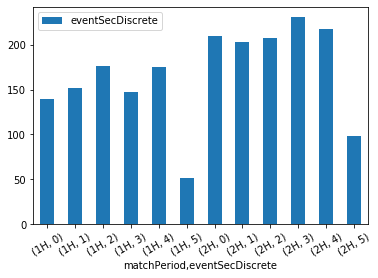

In [6]:
eventGroupSecDiscrete=event.groupby(['matchPeriod', 'eventSecDiscrete']).agg({'eventSecDiscrete':'count'}) #groping on periods and second descrete counting the second discrete
ax=eventGroupSecDiscrete.plot.bar(rot=30)

# ii. Find the top 10 teams that score the most in the interval "81-90"

In [7]:
#filter event by the minutes 81-90 -> (2H, 4) 
event2H4=event.loc[(event['matchPeriod']=='2H') & (event['eventSecDiscrete']==4)]#selection

eventGroupTeams=event2H4.groupby('teamId').agg({'eventSecDiscrete':'count'}) #grouping on teamId and aggregating counting on seconds dicrete


print(eventGroupTeams, end='\n\n')
gt=eventGroupTeams.to_dict()['eventSecDiscrete'] #trasform the dataframe into a ictionary and optain the inside dictionary
print('First 10 team by number of goals')
for w in sorted(gt, key=gt.get, reverse=True)[:10]:#print the first ten sorted elements
  print(w, gt[w])

        eventSecDiscrete
teamId                  
1609                  16
1610                  13
1611                  10
1612                  11
1613                   7
1619                   8
1623                  12
1624                   9
1625                  15
1627                   8
1628                  13
1631                   9
1633                  15
1639                  11
1644                  16
1646                   7
1651                  10
1659                  11
1673                   4
10531                 12

First 10 team by number of goals
1609 16
1644 16
1625 15
1633 15
1610 13
1628 13
1623 12
10531 12
1612 11
1639 11


# iii. Show if there are players that were able to score at least one goal in 8 different intervals

In [24]:
eventWitoutDuplicateOnId_eventSecDiscrete=event.drop_duplicates(['playerId', 'matchPeriod', 'eventSecDiscrete'])
#print(eventWitoutDuplicateOnId_eventSecDiscrete)
eventPlayerGoal=eventWitoutDuplicateOnId_eventSecDiscrete.groupby('playerId').agg({'eventSecDiscrete':'count'})
#eventPlayer8=eventPlayerGoal.loc[eventPlayerGoal[]]
#print(eventPlayerGoal)
eventPlayerGoalDict=eventPlayerGoal['eventSecDiscrete'].to_dict()

#print('Player with at least one goal in 8 different intervals')
for w in eventPlayerGoalDict.keys():#print the first ten sorted elements
    if eventPlayerGoalDict[w]>=8:
        print(w, eventPlayerGoalDict[w])

3324 9
3429 11
3582 11
7847 11
7882 11
7905 9
7910 11
7974 10
8094 11
8266 11
8301 12
8358 12
8391 10
8422 8
8425 11
8480 12
8514 11
8580 10
8717 11
8726 12
10131 11
11066 11
12242 11
12829 11
14703 8
15175 9
15808 8
25381 12
25413 8
26150 9
56038 12
61390 12
61941 10
71654 12
92864 9
120353 11
340386 9


# CRQ2